# Plotting Dataset from Pinkus

Beschreibung von Dataset hier noch einfügen

In [36]:
# Packages

# Model
import numpy as np
import tellurium as te

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Dataframe
import pandas as pd
import dataset_long as dsl

# Clustering
from dtaidistance import clustering
from dtaidistance import dtw
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import cluster

## import Dataframe in long-Format

In [52]:
df = pd.read_excel('/haemolysismodel_conRetis.xlsx')
df = dsl.long_format(df)
#df_long[['time','measurement','patientnumber']].head(10)
df.head(5)

,PTH,patientnumber,Ethnicity,Pittingquote_absolut_modified,Pittingquote_modified,Immunity,Parasite_per_µl,Parasite_%,PfHRP2,Hkt,Ery,Hb,LDH,Hapto,RPI_berechnet,Thrombos,OIE%,OIE_per_µl,time
index,,,,,,,,,,,,,,,,,,,
5,0,101,African,NaN,NaN,non-immune,17500.0,0.5,NaN,0.320,3.5,11.1,170.0,1.76,NaN,115.0,NaN,NaN,0
6,0,101,African,NaN,NaN,non-immune,NaN,NaN,NaN,0.312,3.4,10.6,229.0,1.62,NaN,99.0,NaN,NaN,2
7,0,101,African,NaN,NaN,non-immune,NaN,NaN,NaN,0.297,3.3,10.3,309.0,1.41,1.196601,276.0,0.03628,1197.22944,6
8,0,101,African,NaN,NaN,non-immune,NaN,NaN,NaN,0.340,4.1,12.6,222.0,1.26,2.661505,356.0,NaN,NaN,13
9,0,101,African,NaN,NaN,non-immune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27


## Plotting

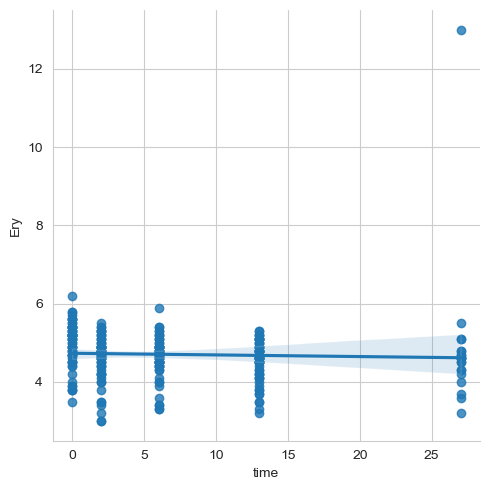

In [46]:
#scatterplot
sns.lmplot(
    x='time', y='Ery', data =df,
    fit_reg=True
    )

<AxesSubplot: >

<Figure size 2100x200 with 0 Axes>

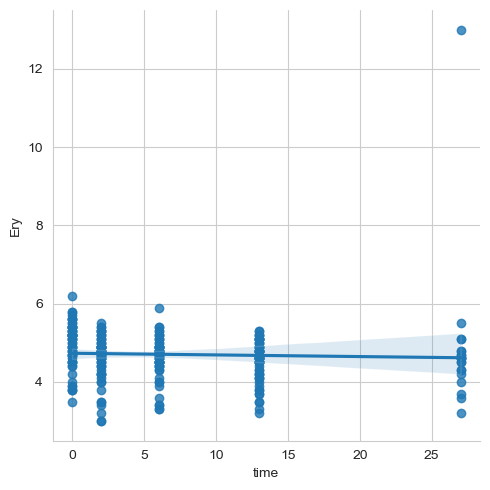

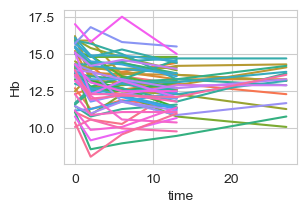

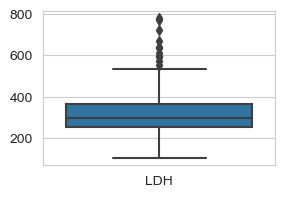

In [47]:
#scatterplot
plt.figure(figsize=(3,2))
sns.lmplot(x='time', y='Ery', data =df,fit_reg=True)

#lineplot
plt.figure( figsize=(3,2))
sns.lineplot(x='time', y='Hb', hue="patientnumber", data =df, legend='')

#boxplot
df_LDH = df[['patientnumber','LDH']]
plt.figure(figsize=(3,2))
sns.boxplot(data=df_LDH)

<AxesSubplot: >

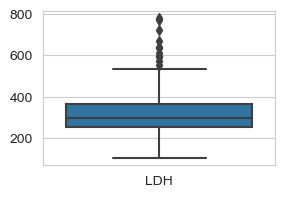

## Hierachical-Clustering
- Clustering (3) von Hb- Zeitverlauf 
- (hoffentlich) ähnlich PADH- Verlauf (s.Rehmann 2014)
- nutzen für Modellfitting


In [6]:
#Prepocessing for Clustering
"""
only important columns, deletes NANs
remove (inside)nans with interpolate -> gegen iterpolate entschieden da alle Datenunkte (nur 5) erheblich für Hb-Verlauf beitragen
"""

#select relevant columns
df_clust = df.copy()
df_clust= df_clust[['patientnumber', 'Hb', 'time','PTH']]

#Clust1: remove rows where time equals 27, remove patients with missing Hb-values
df_clust1_sin5 = df_clust[df_clust['time'] != 27]
df_clust1_sin5 = df_clust1_sin5.groupby(['patientnumber']).filter(lambda group: ~(group['Hb'].isnull().any()))
#sns.lineplot(x='time', y='Hb', hue="patientnumber", data =df_test1_sin5, legend='')

#Clust2: remove patients with nans in Hb (all timepoints)
df_clust2_sinpat = df_clust.groupby(['patientnumber']).filter(lambda group: ~(group['Hb'].isnull().any()))
#sns.lineplot(x='time', y='Hb', hue="patientnumber", data =df_test2_sinpat, legend='')

#Clust3 mit normalisierten Hb werten
df_clust3_norm = df_clust2_sinpat.copy()
# Calculate normalization factor for each patient
df_clust3_norm['Hb_norm_factor'] = df_clust3_norm.groupby('patientnumber')['Hb'].transform('first')
# Normalize Hb values for each patient by dividing by the normalization factor
df_clust3_norm['Hb_normalized'] = df_clust3_norm['Hb'] / df_clust3_norm['Hb_norm_factor']

9.0
3.0
4.0


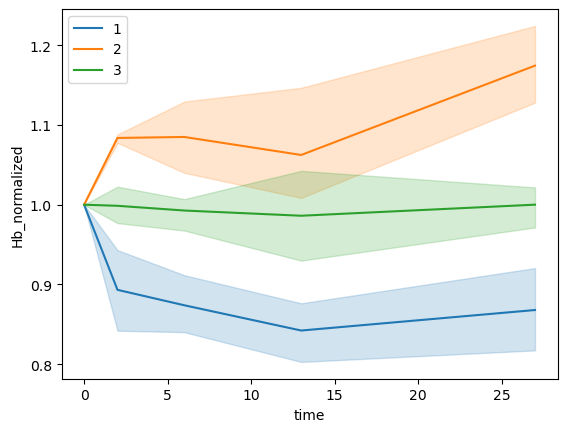

In [7]:
#Hierachical Clustering with DTW 

#Settings
df_clust = df_clust3_norm #df_clust2_sinpat #df_clust1_sin5 #
#df_clust = df_clust[df_clust['patientnumber'] != 'S12']
clust_method = 'complete'  # complete, ward, average, single, (chatgpt vergleichen lassen)
n_clusters = 3
value = 'Hb_normalized' #'Hb'


# Reshape data to wide format with patient ID as columns and Time as index
df_wide = df_clust.pivot(index='patientnumber', columns='time', values= value)  

# Calculate distance matrix using DTW
distances = dtw.distance_matrix(df_wide.values, compact = True)

# Use hierarchical clustering to cluster the patients based on their Hb time series
linkage_matrix = linkage(distances, method= clust_method)

# Assign each patient to a cluster based on the hierarchy and specified number of clusters
cluster_assignments = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Add the cluster assignments as a new column to the original data frame
df_clust['cluster'] = cluster_assignments[df_clust.groupby('patientnumber').ngroup()]

# Plot Dendrogramm
""" fig = plt.figure(figsize=(10, 5))
dn = dendrogram(linkage_matrix, labels = df_wide.index)
plt.show() """

# Plot the Hb time series for each cluster
for cluster_num in range(1,n_clusters+1):
    cluster_data = df_clust.groupby('cluster').get_group(cluster_num)
    print(len(cluster_data)/5)
    sns.lineplot(x='time', y='Hb_normalized', 
             #hue="PTH", 
             data =cluster_data, label = cluster_num)

In [8]:
#Spielerei

df_PTH = df_clust[['patientnumber','PTH','time']] [df_clust.PTH == 1]
df_wide_PTH = df_PTH.pivot(index='patientnumber', columns='time', values='PTH')

df_PTH1 = df[['patientnumber','PTH','time']] [df.PTH == 1]
df_wide_PTH1 = df_PTH1.pivot(index='patientnumber', columns='time', values='PTH')

cluster_data = df_clust.groupby('cluster').get_group(3)
df_clust_wide_PTH = cluster_data.pivot(index='patientnumber', columns='time', values='PTH')

len(df_wide_PTH1), len(df_wide_PTH), len(df_clust_wide_PTH)

#a= df[['patientnumber', 'Hb', 'time', 'PTH']] [df.patientnumber == 'S13']

(26, 10, 4)

## Prepare Data for Model Fitting

In [69]:
# Define lab values to fit in the model
lab_values = [
       'Parasite_%',
       'PfHRP2', 
       'Hkt', 
       'Ery', 
       'Hb',
       'LDH',
       'RPI_berechnet',
       'OIE%', 
       'OIE_per_µl', 
       'Pittingquote_absolut_modified',
       'Pittingquote_modified',
       'Parasite_per_µl']

# Create DataFrame with only PTH cases and group it by time, then calculate mean, standard deviation, and SEM of each lab value
df_PTH = df.loc[df['PTH'] == 1]                                                 
df_input_PTH= df_PTH.groupby('time')[lab_values].agg(['mean', 'std', 'sem'])              # group the dataframe df by the 'time' and calculate  mean, standard deviation and SEM of each lab-value
df_input_PTH.columns = ['{}_{}'.format(col, stat) for col, stat in df_input_PTH.columns]  # rename columns of the resulting df to 'Hb_mean', 'Hb_std', ...

# Create a DataFrame with only non-PTH cases and group it by time, then calculate mean, standard deviation, and SEM of each lab value
df_noPTH = df.loc[df['PTH'] == 0]                                                 
df_input_noPTH= df_noPTH.groupby('time')[lab_values].agg(['mean', 'std', 'sem'])             # group the dataframe df by the 'time' and calculate  mean, standard deviation and SEM of each lab-value
df_input_noPTH.columns = ['{}_{}'.format(col, stat) for col, stat in df_input_noPTH.columns] # rename columns of the resulting df to 'Hb_mean', 'Hb_std', ...

df_input_noPTH

,Parasite_%_mean,Parasite_%_std,Parasite_%_sem,PfHRP2_mean,PfHRP2_std,PfHRP2_sem,Hkt_mean,Hkt_std,Hkt_sem,Ery_mean,...,OIE_per_µl_sem,Pittingquote_absolut_modified_mean,Pittingquote_absolut_modified_std,Pittingquote_absolut_modified_sem,Pittingquote_modified_mean,Pittingquote_modified_std,Pittingquote_modified_sem,Parasite_per_µl_mean,Parasite_per_µl_std,Parasite_per_µl_sem
time,,,,,,,,,,,,,,,,,,,,,
0,0.857714,1.274157,0.215372,81.449826,145.095285,35.190776,0.404800,0.046101,0.007793,4.968571,...,NaN,48.617269,42.181916,9.432163,51.043412,44.734396,10.002915,40559.714286,57835.467923,9775.978358
2,NaN,NaN,NaN,41.290011,115.957806,34.962594,0.388400,0.039610,0.006695,4.711429,...,6946.782600,48.617269,42.181916,9.432163,51.043412,44.734396,10.002915,NaN,NaN,NaN
6,NaN,NaN,NaN,524.871134,NaN,NaN,0.390000,0.042935,0.007474,4.724242,...,8711.898066,48.617269,42.181916,9.432163,51.043412,44.734396,10.002915,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,NaN,NaN,0.387743,0.034817,0.005885,4.685714,...,3183.386676,48.617269,42.181916,9.432163,51.043412,44.734396,10.002915,NaN,NaN,NaN
27,NaN,NaN,NaN,NaN,NaN,NaN,0.399286,0.023887,0.009028,5.622222,...,621.317960,48.617269,42.181916,9.432163,51.043412,44.734396,10.002915,NaN,NaN,NaN


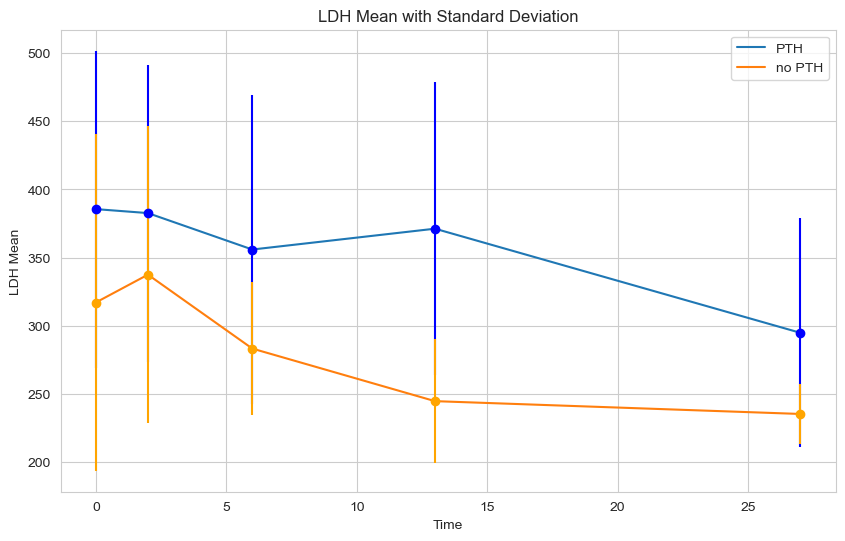

In [68]:
#Little Plotting

# Define lab value to use as time series
time_series = 'Hb_mean'

# Create lineplot for PTH data
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# plot data from df_input_PTH
sns.lineplot(x='time', y='LDH_mean', data=df_input_PTH, label='PTH')
plt.errorbar(x=df_input_PTH.index, y=df_input_PTH['LDH_mean'], yerr=df_input_PTH['LDH_std'], fmt='o', color='blue')

# plot data from df_input_noPTH
sns.lineplot(x='time', y='LDH_mean', data=df_input_noPTH, label='no PTH')
plt.errorbar(x=df_input_noPTH.index, y=df_input_noPTH['LDH_mean'], yerr=df_input_noPTH['LDH_std'], fmt='o', color='orange')

# set plot labels and legend
plt.xlabel('Time')
plt.ylabel('LDH Mean')
plt.title('LDH Mean with Standard Deviation')
plt.legend()

# show the plot
plt.show()